##Import libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import applications
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd gdrive/MyDrive/PetImages

/content/gdrive/MyDrive/PetImages


In [ ]:
#creating validation set for dogs
import shutil
import os 
x = []
x2 = []
for i in os.listdir('./PetImages/train/dogs/'):
  x.append(i)

x2 = x[len(x)-400:]

for i in x2:
  src_path = os.path.join('./PetImages/train/dogs/', i)
  shutil.copyfile(src_path, os.path.join('./PetImages/validation/dogs/', i))
  

In [ ]:
#creating validation set for cats
import shutil
x = []
x2 = []
for i in os.listdir('PetImages/train/cats/'):
  x.append(i)

x2 = x[len(x)-400:]

for i in x2:
  src_path = os.path.join('PetImages/train/cats/', i)
  shutil.copyfile(src_path, os.path.join('PetImages/validation/cats/', i))

##Initialization

In [4]:
#VGG16
# dimensions of our images.
img_width, img_height = 150, 150
# path to the model weights files.
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = r'train'
validation_data_dir = r'validation'
nb_train_samples = 3000
nb_validation_samples = 800
epochs = 50
batch_size = 16

##Record bottleneck features

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255)

# build the VGG16 network
model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

bottleneck_features_train = model.predict(
    generator, nb_train_samples // batch_size)

np.save(open('bottleneck_features_train.npy', 'wb'),
      bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = model.predict(
    generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'wb'),
      bottleneck_features_validation)

58900480/58889256 [==============================] - 0s 0us/step
Found 3000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Found 800 images belonging to 2 classes.


##Model

In [6]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array(
    [0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array(
    [0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])

##Train

Epoch 1/50
188/188 [==============================] - 4s 12ms/step - loss: 0.7359 - accuracy: 0.6423 - val_loss: 0.5411 - val_accuracy: 0.7188
Epoch 2/50
188/188 [==============================] - 2s 10ms/step - loss: 0.5731 - accuracy: 0.7053 - val_loss: 0.5301 - val_accuracy: 0.7200
Epoch 3/50
188/188 [==============================] - 2s 12ms/step - loss: 0.5447 - accuracy: 0.7377 - val_loss: 0.4252 - val_accuracy: 0.8025
Epoch 4/50
188/188 [==============================] - 1s 7ms/step - loss: 0.5095 - accuracy: 0.7523 - val_loss: 0.3841 - val_accuracy: 0.8388
Epoch 5/50
188/188 [==============================] - 1s 6ms/step - loss: 0.4645 - accuracy: 0.7680 - val_loss: 0.3648 - val_accuracy: 0.8413
Epoch 6/50
188/188 [==============================] - 1s 7ms/step - loss: 0.4498 - accuracy: 0.7940 - val_loss: 0.3515 - val_accuracy: 0.8313
Epoch 7/50
188/188 [==============================] - 1s 6ms/step - loss: 0.4200 - accuracy: 0.8113 - val_loss: 0.3286 - val_accuracy: 0.8700
Epo

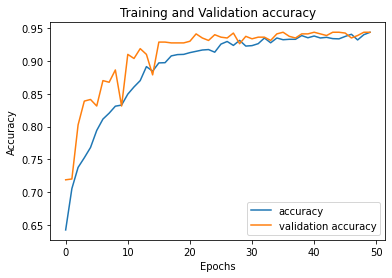

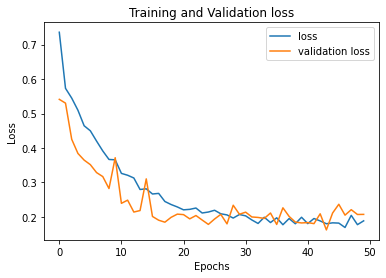

In [7]:
history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights(top_model_weights_path)

## plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation accuracy')
plt.legend(['accuracy','validation accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.legend(['loss','validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()